# Assignment 8 #

### Imports and Cleaning ###

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tiingo import TiingoClient
import numpy as np
from datetime import date
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
config = {}

config['session'] = True

config['api_key'] = "110ee73e29ec4269f49eb85cfb4b976ab8e73361"

client = TiingoClient(config)

In [2]:
def download_financial_data(ticker):
    fin_data = client.get_ticker_price(ticker,
                                       fmt='csv',
                                       startDate = date.today() - relativedelta(years=5),
                                       endDate = date.today(),
                                       frequency = 'daily')
    file_name = f"{ticker}.csv"
    with open(file_name,'w') as outfile:
        outfile.write(fin_data)
    print(f'{ticker}.csv created')
    return pd.read_csv(f"{ticker}.csv")

In [4]:
spy_df = download_financial_data("SPY")
aapl_df = download_financial_data("AAPL")
wfc_df = download_financial_data("WFC")
ibm_df = download_financial_data("IBM")
print(spy_df.shape,aapl_df.shape,tlsa_df.shape,ibm_df.shape)

SPY.csv created
AAPL.csv created
WFC.csv created
IBM.csv created
(1260, 13) (1260, 13) (890, 13) (1260, 13)


In [5]:
spy_df['date'] = pd.to_datetime(spy_df['date'])
aapl_df['date'] = pd.to_datetime(aapl_df['date'])
wfc_df['date'] = pd.to_datetime(wfc_df['date'])
ibm_df['date'] = pd.to_datetime(ibm_df['date'])

In [6]:
spy_df = spy_df[['date','adjClose']]
spy_df = spy_df.rename(columns = {'adjClose':'spy_adjClose'})
aapl_df = aapl_df[['date','adjClose']]
aapl_df = aapl_df.rename(columns = {'adjClose':'aapl_adjClose'})
wfc_df = wfc_df[['date','adjClose']]
wfc_df = wfc_df.rename(columns = {'adjClose':'wfc_adjClose'})
ibm_df = ibm_df[['date','adjClose']]
ibm_df = ibm_df.rename(columns = {'adjClose':'ibm_adjClose'})

In [7]:
df = spy_df.merge(aapl_df,on="date")

In [8]:
df.head()

,date,spy_adjClose,aapl_adjClose
0,2017-06-05,223.474004,36.423468
1,2017-06-06,222.759592,36.546512
2,2017-06-07,223.171751,36.764206
3,2017-06-08,223.281656,36.674289
4,2017-06-09,222.942773,35.252181


In [9]:
df = df.merge(wfc_df, on="date")
df = df.merge(ibm_df,on = "date")

In [10]:
df.head()

,date,spy_adjClose,aapl_adjClose,wfc_adjClose,ibm_adjClose
0,2017-06-05,223.474004,36.423468,44.751778,115.023259
1,2017-06-06,222.759592,36.546512,44.829652,114.993071
2,2017-06-07,223.171751,36.764206,45.071928,113.944043
3,2017-06-08,223.281656,36.674289,45.478605,114.789303
4,2017-06-09,222.942773,35.252181,46.551540,116.298695


In [19]:
df['spy_ret'] = df['spy_adjClose'].pct_change(1)
df['aapl_ret'] = df['aapl_adjClose'].pct_change(1)
df['wfc_ret'] = df['wfc_adjClose'].pct_change(1)
df['ibm_ret'] = df['ibm_adjClose'].pct_change(1)
df = df.dropna()

### Models and Regplots ###

In [24]:
import statsmodels.api as sm
from statsmodels import regression

In [35]:
def compute_lin_reg(index,stock):
    x = index
    y = stock
    
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    x = x.drop(columns = 'const')
    return model.params[0],model.params[1]

In [38]:
alpha1, beta1 = compute_lin_reg(df['spy_ret'],df['aapl_ret'])
alpha2, beta2 = compute_lin_reg(df['spy_ret'],df['wfc_ret'])
alpha3, beta3 = compute_lin_reg(df['spy_ret'],df['ibm_ret'])

In [41]:
print(f"AAPL alpha: {alpha1} beta: {beta1} \n" 
      f"WFC alpha: {alpha2} beta: {beta2} \n"
      f"IBM alpha: {alpha3} beta: {beta3}")

AAPL alpha: 0.0006012893891899257 beta: 1.2425747689763638 
WFC alpha: -0.00042681058056712526 beta: 1.2242362038625618 
IBM alpha: -0.0001982751420146708 beta: 0.8992993437199236


In [43]:
def create_reg_plot(index,stock):
    alpha, beta = compute_lin_reg(index,stock)
    x2 = np.linspace(index.min(),index.max(),100)
    y_hat = x2 * beta + alpha
    plt.figure(figsize=(10,7))
    plt.scatter(index,stock,alpha=.3)
    plt.xlabel("index daily returns")
    plt.ylabel("stock daily returns")
    
    plt.plot(x2,y_hat,'r',alpha=.9)
    plt.show()

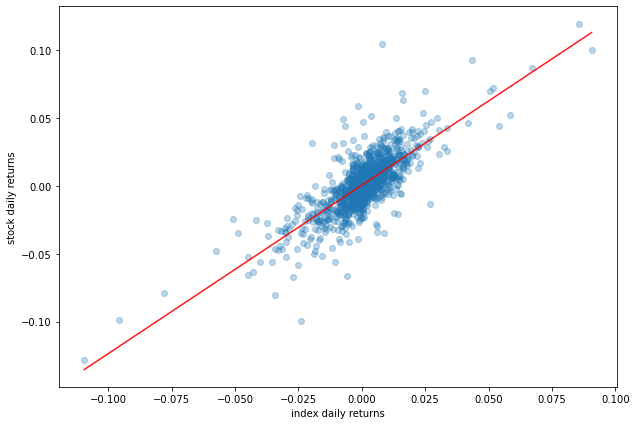

In [44]:
create_reg_plot(df['spy_ret'],df['aapl_ret'])

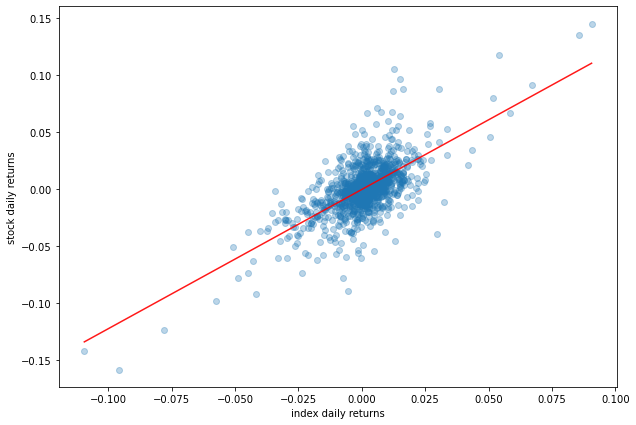

In [45]:
create_reg_plot(df['spy_ret'],df['wfc_ret'])

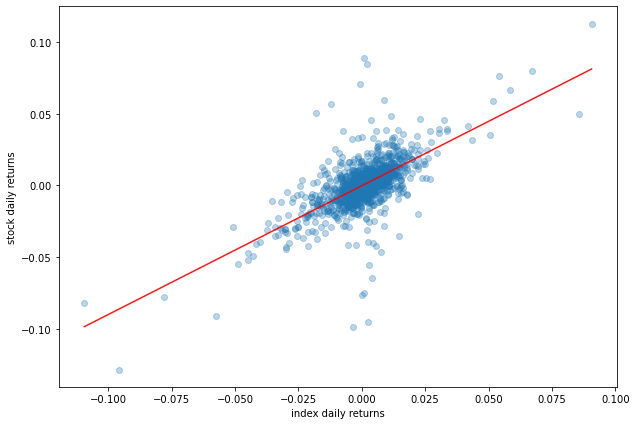

In [46]:
create_reg_plot(df['spy_ret'],df['ibm_ret'])